In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore

import utils # all datareading and preprocessing functionality
import entrez_utils # all functions for querying NCBI Entrez

## Validation data

Read and process the "gold standard" data.

In [2]:
curated_pesticide_papers = pd.read_csv('./data/curated_pesticides.txt', sep='\t')
curated_pesticide_papers

,pmid,label,tenwise_id,pesticide
0,10234476,animal,TWPHI_00010,carbaryl
1,10369463,human,TWPHI_00003,acetamiprid
2,10583056,human,TWPHI_00010,carbaryl
3,15496540,human,TWPHI_00072,pendimethalin
4,16452832,human,TWPHI_00072,pendimethalin
...,...,...,...,...
159,39415959,animal,TWPHI_00003,acetamiprid
160,39415959,animal,TWPHI_00012,clothianidin
161,39415959,animal,TWPHI_00025,imidacloprid
162,39419870,other,TWPHI_00025,imidacloprid


Fetch abstracts belonging to theses pmid's.

In [ ]:
#entrez_utils.init('20af26e91ae36b8ec830da38ca84b872a209', 'michiel.noback@gmail.com')

In [3]:
pub_ids=curated_pesticide_papers['pmid'].to_list()
print(len(pub_ids))
pub_ids[:10]

164


[10234476,
 10369463,
 10583056,
 15496540,
 16452832,
 16704049,
 19248625,
 19934164,
 22361216,
 22393406]

In [ ]:
# from importlib import reload
# reload(entrez_utils)

In [ ]:
# not required to repeat
#entrez_utils.fetch_abstracts(pub_ids=pub_ids, 
#                             output_file='./data/curated_pesticides_abstracts.txt')

In [4]:
# check the new file
curated_pesticide_abstracts = pd.read_csv('./data/curated_pesticides_abstracts.txt', sep='\t')
print(curated_pesticide_abstracts.shape)
curated_pesticide_abstracts.head(10)

(152, 3)


,pmid,title,abstract
0,10234476,Pesticide induced changes of nitric oxide synt...,Organic insecticides are well known neurotoxic...
1,10369463,Minor structural changes in nicotinoid insecti...,The major nitroimine insecticide imidacloprid ...
2,10583056,Evidence for double resistance to permethrin a...,A rising prevalence of head lice among school ...
3,15496540,Pesticides and lung cancer risk in the agricul...,The authors examined the relation between 50 w...
4,16452832,Pendimethalin exposure and cancer incidence am...,"Pendimethalin, a widely used herbicide, has be..."
5,16704049,Dose-additive inhibition of chinook salmon ace...,Organophosphate and carbamate insecticides are...
6,19248625,[The effect of pesticide acetamiprid on bioche...,The effects of ecological real concentration o...
7,19934164,"Time-course, dose-response, and age comparativ...",N-Methyl carbamate insecticides are reversible...
8,22361216,Effect of chronic exposure to pendimethalin on...,"In this study, the in vivo effects of chronic ..."
9,22393406,Nicotine-like effects of the neonicotinoid ins...,Acetamiprid (ACE) and imidacloprid (IMI) belon...


Strangely enough, 12 papers seem to be lost in this procedure. I will investigate this a bit.

In [5]:
# import Counter to check for duplicates
from collections import Counter
duplicates = [(item, count) for item, count in Counter(pub_ids).items() if count > 1]
duplicates


[(26990785, 2),
 (28385489, 2),
 (29151145, 2),
 (29374591, 2),
 (33288284, 2),
 (38470098, 2),
 (38581179, 2),
 (38799264, 2),
 (39162819, 2),
 (39359636, 2),
 (39415959, 3)]

Apparently, there were 10 duplicates in the collection, as well as one triplicate.  
Otherwise, it seems to be OK. On 2025-04-09 I have already downloaded a baseline set, i.e. all the abstracts that were published on that day.  
Now I fetch another set, to get some body.

In [ ]:
# not required to repeat
#yesterdays_papers = entrez_utils.query_pubmed_by_date() #defaults to yesterday
#len(yesterdays_papers)

In [ ]:
# not required to repeat
#entrez_utils.fetch_abstracts(pub_ids=yesterdays_papers, 
#                             output_file='./data/abstracts_2025_04_15.csv', chunksize = 2500)

Now combine all into one validation set.

In [6]:
set1 = pd.read_csv('./data/abstracts_2025_04_09.csv', sep='\t')
print(set1.shape)
set1.dropna(subset=['abstract'], inplace=True)
print(set1.shape)

(2907, 3)
(2573, 3)


In [7]:
set2 = pd.read_csv('./data/abstracts_2025_04_15.csv', sep='\t')
print(set2.shape)
set2.dropna(subset=['abstract'], inplace=True)
print(set2.shape)

(2375, 3)
(2136, 3)


In [8]:
# concat set 1 and set 2
baseline_abstracts = pd.concat([set1, set2], axis=0)
print(baseline_abstracts.shape)
baseline_abstracts = baseline_abstracts.drop_duplicates(subset=['pmid'], keep='first')
print(baseline_abstracts.shape)

(4709, 3)
(4708, 3)


In [9]:
baseline_abstracts['label'] = 0
baseline_abstracts['text_label'] = 'not_pesticide'

baseline_abstracts

,pmid,title,abstract,label,text_label
1,40205634,A Python package for fast GPU-based proton pen...,Open-source GPU-based Monte Carlo (MC) proton ...,0,not_pesticide
8,40205627,Efficacy and Safety of Direct Oral Anti-Coagul...,"Direct oral anticoagulants (DOAC), including d...",0,not_pesticide
9,40205626,Design and validation of a novel dosimetry pha...,We present a novel phantom design for conducti...,0,not_pesticide
10,40205625,Associations of neighbourhood walkability with...,Neighbourhood walkability is known to be posit...,0,not_pesticide
11,40205624,Psychometric evaluation of the problem areas i...,to assesses the psychometric properties of the...,0,not_pesticide
...,...,...,...,...,...
2370,39198200,Enhanced functionality and migration of human ...,The maintenance of peri-implant health relies ...,0,not_pesticide
2371,39198199,Effect of build orientation on the wear resist...,This in vitro study investigated the effect of...,0,not_pesticide
2372,39034113,Effect of wall thickness on shape accuracy of ...,This study aimed to analyze how the wall thick...,0,not_pesticide
2373,38925985,Dental human enamel wear caused by ceramic ant...,Fixed restorations and dental enamel have diff...,0,not_pesticide


In [10]:
curated_pesticide_abstracts['label'] = 1
curated_pesticide_abstracts['text_label'] = 'pesticide'
curated_pesticide_abstracts

,pmid,title,abstract,label,text_label
0,10234476,Pesticide induced changes of nitric oxide synt...,Organic insecticides are well known neurotoxic...,1,pesticide
1,10369463,Minor structural changes in nicotinoid insecti...,The major nitroimine insecticide imidacloprid ...,1,pesticide
2,10583056,Evidence for double resistance to permethrin a...,A rising prevalence of head lice among school ...,1,pesticide
3,15496540,Pesticides and lung cancer risk in the agricul...,The authors examined the relation between 50 w...,1,pesticide
4,16452832,Pendimethalin exposure and cancer incidence am...,"Pendimethalin, a widely used herbicide, has be...",1,pesticide
...,...,...,...,...,...
147,39399211,Cytotoxicity induced by three commercial neoni...,Neonicotinoid insecticides are used worldwide ...,1,pesticide
148,39402966,Toxicity of pesticide cocktails in amphibian l...,Aquatic communities are increasingly exposed t...,1,pesticide
149,39415959,Neonicotinoid pesticides: evidence of developm...,Neonicotinoids are the most widely used class ...,1,pesticide
150,39419870,An overview on the fate and behavior of imidac...,This review provides an overview on the fate a...,1,pesticide


In [11]:
# concat baseline with curated set
validation_abstracts = pd.concat([baseline_abstracts, curated_pesticide_abstracts], axis=0)
print(validation_abstracts.shape)
# just to be sure: remove duplicates (not likely given this setup)
validation_abstracts = validation_abstracts.drop_duplicates(subset=['pmid'], keep='first')
print(validation_abstracts.shape)

(4860, 5)
(4860, 5)


In [12]:
validation_abstracts['text_label'].value_counts()

text_label
not_pesticide    4708
pesticide         152
Name: count, dtype: int64

In [13]:
# create abstract and title columns lowercase and without punctuation
utils.preprocess_text(validation_abstracts)
validation_abstracts.head(3)

,pmid,title,abstract,label,text_label,title_clean,abstract_clean
1,40205634,A Python package for fast GPU-based proton pen...,Open-source GPU-based Monte Carlo (MC) proton ...,0,not_pesticide,a python package for fast gpu-based proton pen...,open-source gpu-based monte carlo (mc) proton ...
8,40205627,Efficacy and Safety of Direct Oral Anti-Coagul...,"Direct oral anticoagulants (DOAC), including d...",0,not_pesticide,efficacy and safety of direct oral anti-coagul...,"direct oral anticoagulants (doac), including d..."
9,40205626,Design and validation of a novel dosimetry pha...,We present a novel phantom design for conducti...,0,not_pesticide,design and validation of a novel dosimetry pha...,we present a novel phantom design for conducti...


In [14]:
#shuffle to prevent batch effects
validation_abstracts = validation_abstracts.sample(frac=1, random_state=42).reset_index(drop=True)
#reset the index
validation_abstracts = validation_abstracts.reset_index(drop=True)
#validation_abstracts['text_label'][:50]

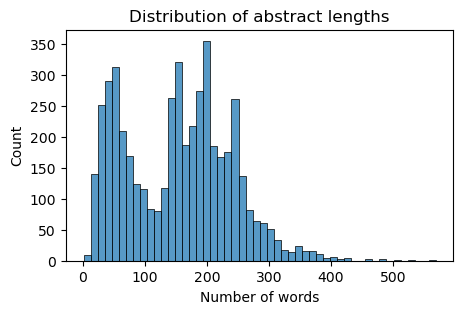

In [16]:
# get a picture of the lengths distribution of the abstracts
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.histplot(validation_abstracts['abstract'].str.split().str.len(), bins=50)
plt.title('Distribution of abstract lengths')
plt.xlabel('Number of words')
plt.ylabel('Count')
#plt.savefig('./figures/abstract_lengths.png', dpi=300, bbox_inches='tight')
plt.show()

That is a strangely bi- or multimodal distribution.  I see sharp drops before 100, 150, 200 and 250 words.  
That has probably to do with the specific requirements posed by the individual journals to which they were submitted.  
However, this is going to be a problem when using the longer abstracts in the context of transformers: they have 
an upper length limit of 512 **after their own tokenization** which, so it seems, can get very high (see notebook `transformers_feature_extraction.ipynb`)

## Train / test data

For model development, I will start with the first collection, load it as always and remove any papers of the curated set from this one, to really have unseen data in the validation dataset.

In [ ]:
file1 = './data/abstract_set1.txt'
file2 = './data/abstract_set2.txt'
data_selection = 'abstract'
label_selection = 'label' # can be 'label' or 'text_label'
train_test = utils.read_abstract_data(negatives_path=file2, positives_path=file1)
train_test.head()

In [ ]:
# create abstract and title columns lowercase and without punctuation
utils.preprocess_text(train_test)
train_test.head(3)

In [ ]:
#shuffle to prevent batch effects
train_test = train_test.sample(frac=1, random_state=42).reset_index(drop=True)
# reset the index
train_test = train_test.reset_index(drop=True)

train_test['text_label'][:20]

## Split train/test
For now, I will work wth the original, non preprocessed abstracts because they are more suitable for CNNs, the 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_test[data_selection], train_test[label_selection], random_state=123)
x_train.head()

## Optimize CNN classifier

In [ ]:
# number of classes
K = train_test[label_selection].max() + 1
K

In [ ]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 3000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE) # tokenizer from tensorflow.keras.preprocessing.text
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train) # returns a simple python list of lists (of numbers)
sequences_test = tokenizer.texts_to_sequences(x_test)
print(f'train sequences: {len(sequences_train)}; test sequences: {len(sequences_test)}')



## Explore Vector "landscape"

In [ ]:
#stopwords = utils.get_stopwords(custom = {'wa', 'use', 'using', 'one', 'two', 'three', 'study'}) 
#tokenizer = utils.Tokenizer(stop_words=stopwords, min_length=3)

# Here, I will use TF-IDF out of the box
#vectorizer = TfidfVectorizer(max_features=MAX_VOCAB_SIZE)